https://stepik.org/lesson/501479/step/1?unit=493164  
https://drive.google.com/drive/folders/15UoRIwvCOZ-6c624m5NTDfbFizOs-C0N  
https://www.kaggle.com/c/advanced-dls-spring-2021/  

Kaggle Team: **Valentin_Aliferov** (0.85303)

In [188]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import FunctionTransformer

In [2]:
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

target_col = 'Churn'

In [3]:
# loading data
test_data = pd.read_csv('./test.csv')
train_data = pd.read_csv('./train.csv')

In [4]:
# imbalanced classes (but not too much)
print(f'{train_data[target_col].mean() * 100:.1f}% class 1 (target)')

26.2% class 1 (target)


In [5]:
# no missing values in categorical features
test_cat_na = test_data[cat_cols].isna().sum().sum()
train_cat_na = train_data[cat_cols].isna().sum().sum()
print(f'cat_cols_na: {train_cat_na}, {test_cat_na} (train, test)')

cat_cols_na: 0, 0 (train, test)


In [6]:
# Numerical Features (train)
# TotalSpent: wrong dtype
# TotalSpent: 9 missing values
# ClientPeriod: 9 zeros (missing values)
data = train_data[num_cols].copy()
data['TotalSpent_float'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
pd.DataFrame({'dtype': data.dtypes, 'na': data.isna().sum(), 'zero': (data == 0).sum()})

,dtype,na,zero
ClientPeriod,int64,0,9
MonthlySpending,float64,0,0
TotalSpent,object,0,0
TotalSpent_float,float64,9,0


In [7]:
# Numerical Features (test)
# TotalSpent: wrong dtype
# TotalSpent: 2 missing values
# ClientPeriod: 2 zeros (missing values)
data = test_data[num_cols].copy()
data['TotalSpent_float'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
pd.DataFrame({'dtype': data.dtypes, 'na': data.isna().sum(), 'zero': (data == 0).sum()})

,dtype,na,zero
ClientPeriod,int64,0,2
MonthlySpending,float64,0,0
TotalSpent,object,0,0
TotalSpent_float,float64,2,0


,size,mean,median,mode,std,na,zero
HasContractPhone,,,,,,,
Month-to-month,2920,18.147603,12,1,17.684934,0,0
One year,1082,41.929760,44,53,18.891057,0,1
Two year,1280,56.845312,65,72,18.291818,0,8


,size,mean,median,mode,std,na,zero
HasContractPhone,,,,,,,
Month-to-month,955,17.697382,12,1,17.706599,0,0
One year,391,42.363171,44,69,19.452007,0,0
Two year,415,56.395181,63,72,17.970265,0,2


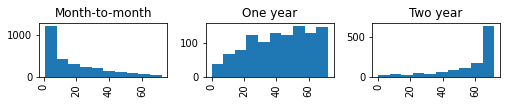

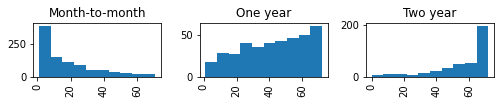

In [8]:
# ClientPeriod: choosing strategy for filling zeros
# 'HasContractPhone': min std within groups
# We can fill missing values with median of each group

def filling_zeros_strategy_report(data):
    def na(x): return x.isnull().sum()
    def zero(x): return (x == 0).sum()
    def mode(x): return x.value_counts().index[0]
    agg_funcs = ('size','mean','median',mode,'std',na,zero)
    display(data.groupby('HasContractPhone')['ClientPeriod'].agg(agg_funcs))
    data.hist(column='ClientPeriod', by='HasContractPhone', layout=(1,3), figsize=(8,1))

filling_zeros_strategy_report(train_data.copy())
filling_zeros_strategy_report(test_data.copy())

In [9]:
# ClientPeriod: checking strategy

def check_filling_zeros(data):
    # x.mean(), x.median(), stats.mode(x)[0][0]
    replace = lambda x: x.replace(0, x.median())
    idx = data[data['ClientPeriod'] == 0].index
    data['ClientPeriod'] = data.groupby('HasContractPhone')['ClientPeriod'].apply(replace)
    display(data.loc[idx,['ClientPeriod','HasContractPhone']])

check_filling_zeros(train_data.copy())
check_filling_zeros(test_data.copy())

,ClientPeriod,HasContractPhone
1048,65.0,Two year
1707,65.0,Two year
2543,44.0,One year
3078,65.0,Two year
3697,65.0,Two year
4002,65.0,Two year
4326,65.0,Two year
4551,65.0,Two year
4598,65.0,Two year


,ClientPeriod,HasContractPhone
177,63.0,Two year
767,63.0,Two year


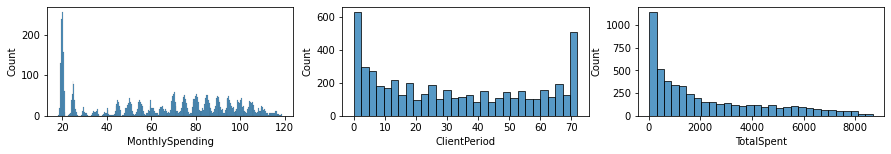

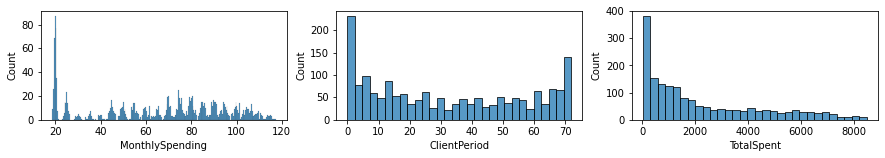

In [10]:
# MonthlySpending: multimodal normal distribution
# We can cut this feature accordingly into bins

def show_num_distributions(data):
    data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
    fig, axes = plt.subplots(1,3,figsize=(15,2))
    sns.histplot(data['MonthlySpending'], bins=250, ax=axes[0])
    sns.histplot(data['ClientPeriod'], bins=30, ax=axes[1])
    sns.histplot(data['TotalSpent'], bins=30, ax=axes[2]);

show_num_distributions(train_data.copy())
show_num_distributions(test_data.copy())

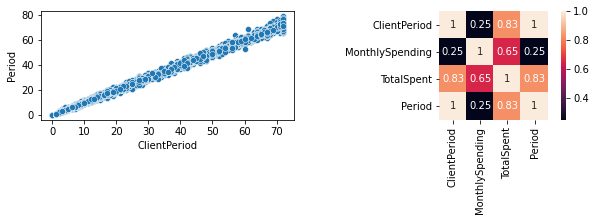

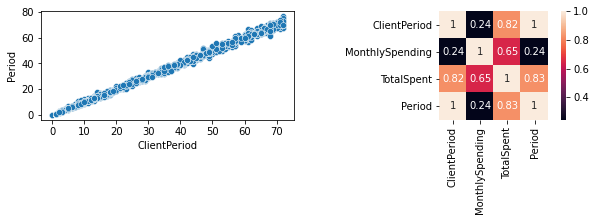

In [11]:
# Checking correlation between numerical variables
# ClientPeriod ~= TotalSpent / MonthlySpending
# Each of them can be linearly reconstructed from the others
# Maybe we shouldn't use one of these features

def show_correlation(data):
    num_cols_ = num_cols + ['Period']
    data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce').fillna(0)
    data['Period'] = data['TotalSpent'] / data['MonthlySpending']
    fig, axes = plt.subplots(1,2,figsize=(10,2))
    sns.scatterplot(x='ClientPeriod', y='Period', data=data, ax=axes[0])
    sns.heatmap(data[num_cols_].corr(method='pearson').abs(), annot=True, square=True, ax=axes[1]);

show_correlation(train_data.copy())
show_correlation(test_data.copy())

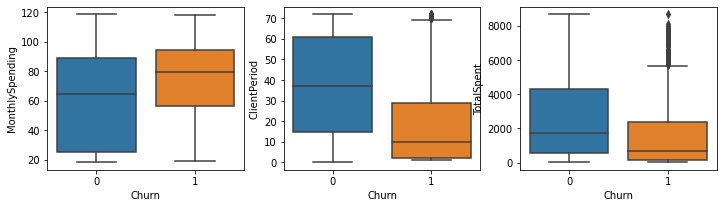

In [12]:
# Looking for outliers
# ClientPeriod: there are some (Churn = 1)
# TotalSpent: there are some (Churn = 1)
fig, axes = plt.subplots(1,3,figsize=(12,3))
train_data['TotalSpent'] = pd.to_numeric(train_data['TotalSpent'], errors='coerce')
sns.boxplot(x='Churn', y='MonthlySpending', data=train_data, ax=axes.flat[0])
sns.boxplot(x='Churn', y='ClientPeriod', data=train_data, ax=axes.flat[1])
sns.boxplot(x='Churn', y='TotalSpent', data=train_data, ax=axes.flat[2]);

In [116]:
# Checking for outliers
# ClientPeriod: 18 outliers (Churn = 1, > 69.5)
# TotalSpent: 74 putliers (Churn = 1, > 5679.4)

def check_outliers(c):
    Q1 = c.quantile(0.25)
    Q3 = c.quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR
    print(f'Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}')
    print(f'low: {low:.2f}, high: {high:.2f}')
    print(f'outliers: {((c < low) | (c > high)).sum()}')

data = train_data.copy()
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
check_outliers(data[data['Churn'] == 1]['ClientPeriod'])
check_outliers(data[data['Churn'] == 1]['TotalSpent'])
# check_outliers(data[data['HasContractPhone'] == 'Month-to-month']['ClientPeriod'])
# check_outliers(data[data['HasContractPhone'] == 'Month-to-month']['TotalSpent'])

Q1: 2.00, Q3: 24.00, IQR: 22.00
low: -31.00, high: 57.00
outliers: 16
Q1: 112.82, Q3: 1874.62, IQR: 1761.80
low: -2529.88, high: 4517.32
outliers: 66


In [14]:
data[(data['ClientPeriod'] > 69.5) & (data['Churn'] == 1)].shape

(18, 20)

In [15]:
data[(data['TotalSpent'] > 5679.4) & (data['Churn'] == 1)].shape

(74, 20)

In [16]:
# Checking replacing outliers (including zeros)

def check_replacing_outliers(data, column, threshold):
    mask = (data[column] > threshold) & (data['Churn'] == 1)
    idx = data[mask].index
    data.loc[mask, column] = 0
    replace = lambda x: x.replace(0, x.median())
    data[column] = data.groupby('HasContractPhone')[column].apply(replace)
    display(data.loc[idx, ['HasContractPhone', column]])

data = train_data.copy()
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce').fillna(0)
check_replacing_outliers(data, 'ClientPeriod', 69.5)
check_replacing_outliers(data, 'TotalSpent', 5679.4)

,HasContractPhone,ClientPeriod
506,One year,43.0
565,Two year,64.0
927,One year,43.0
1263,One year,43.0
1415,Two year,64.0
1756,Two year,64.0
1827,One year,43.0
1873,Two year,64.0
1933,Two year,64.0
2089,Two year,64.0


,HasContractPhone,TotalSpent
24,One year,2483.825
35,One year,2483.825
59,One year,2483.825
83,Month-to-month,664.400
246,One year,2483.825
...,...,...
5102,Two year,3470.650
5111,Month-to-month,664.400
5135,One year,2483.825
5190,Two year,3470.650


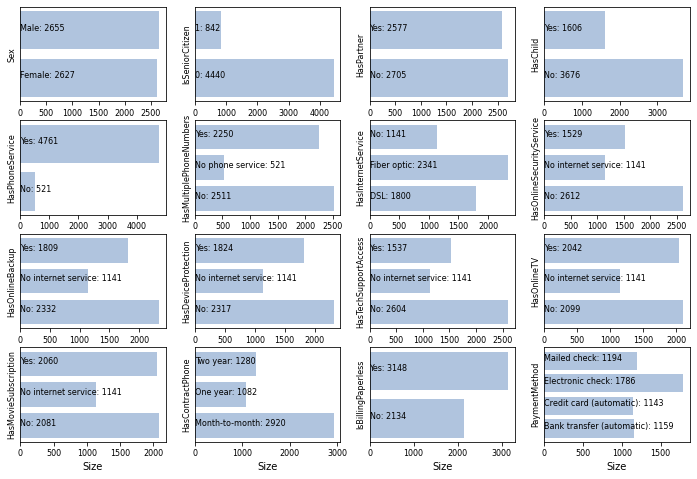

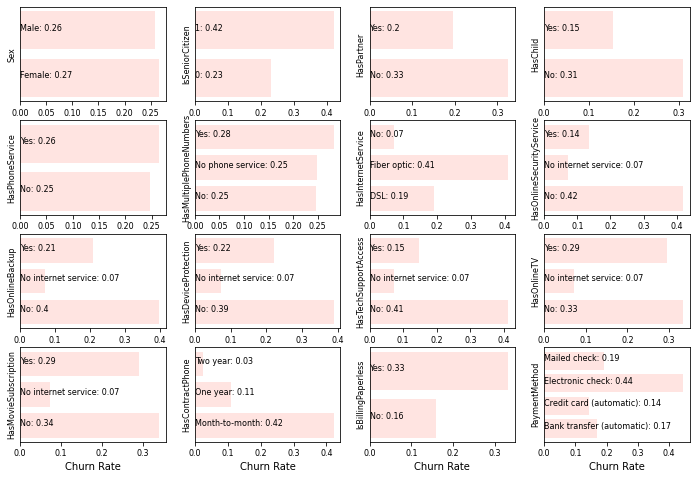

In [17]:
# Distribution of categorical features
# And their correlation with the target

def show_cat_report(data, cols, n_cols, target=None, figsize=(5,5)):
    n_rows = int(np.ceil(len(cols) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    for c, ax in zip(cols, axes.flat):
        g = data.groupby(c)
        cnt = g[target].mean() if target else g.size()
        color = 'mistyrose' if target else 'lightsteelblue'
        ax.barh(cnt.index.astype(str), cnt.values, color=color)
        ax.set_yticks([])
        ax.set_ylabel(c, fontsize=8)
        ax.set_xlabel(target + ' Rate' if target else 'Size')
        ax.tick_params(axis='x', labelsize=8)
        z = zip(range(len(cnt)), cnt.index, cnt.values)
        for i, k, v in z: ax.text(0, i, f'{k}: {round(v,2)}', fontsize=8)

show_cat_report(train_data.copy(), cat_cols, n_cols=4, figsize=(12,8))
show_cat_report(train_data.copy(), cat_cols, n_cols=4, figsize=(12,8), target='Churn')

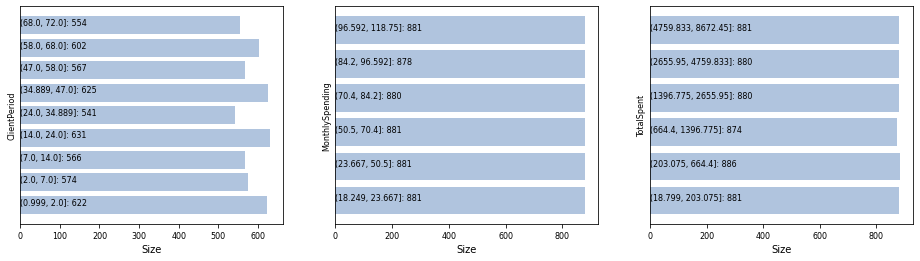

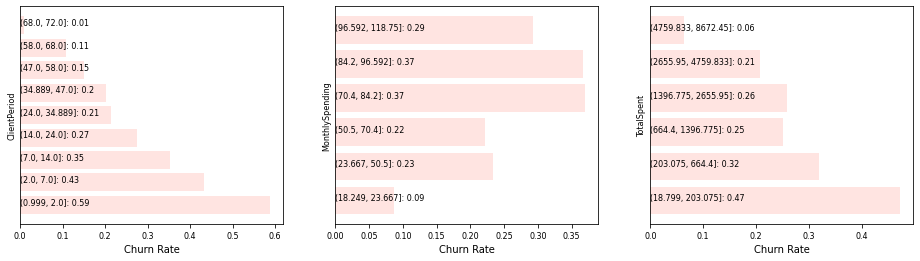

In [18]:
# Distribution of numeric variables (cut into bins)
# And their correlation with the target

data = train_data.copy()
replace = lambda x: x.replace(0, x.median())
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce').fillna(0)
data.loc[(data['ClientPeriod'] > 69.5) & (data['Churn'] == 1), 'ClientPeriod'] = 0
data.loc[(data['TotalSpent'] > 5679.4) & (data['Churn'] == 1), 'TotalSpent'] = 0
data['TotalSpent'] = data.groupby('HasContractPhone')['TotalSpent'].apply(replace)
data['ClientPeriod'] = data.groupby('HasContractPhone')['ClientPeriod'].apply(replace)
# data['MonthlySpending'] = pd.cut(data['MonthlySpending'], bins=np.arange(17.5,125,5))
data['MonthlySpending'] = pd.qcut(data['MonthlySpending'], 6)
data['ClientPeriod'] = pd.qcut(data['ClientPeriod'], 9)
data['TotalSpent'] = pd.qcut(data['TotalSpent'], 6)

cols = ['ClientPeriod','MonthlySpending','TotalSpent']
show_cat_report(data, cols, n_cols=3, figsize=(16,4))
show_cat_report(data, cols, n_cols=3, figsize=(16,4), target='Churn')

In [150]:
data = pd.read_csv('./train.csv')
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce').fillna(0)
data_ = data[((data['TotalSpent'] <= 5679.4) & (data['Churn'] == 1) | (data['Churn'] == 0))]
data.shape[0] - data_.shape[0]

74

In [152]:
data = pd.read_csv('./train.csv')
data_ = data[((data['ClientPeriod'] <= 69.5) & (data['Churn'] == 1) | (data['Churn'] == 0))]
data.shape[0] - data_.shape[0]

18

In [153]:
data.shape[0] - data[data['ClientPeriod'] != 0].shape[0]

9

In [151]:
data.shape[0] - data[data['TotalSpent'] != 0].shape[0]

9

In [202]:
# LogisticRegression (new)

def prepare_data(data, train=False):
    
    data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce').fillna(0)
    
    # if train: data.loc[(data['TotalSpent'] > 5679.4) & (data['Churn'] == 1), 'TotalSpent'] = 0
    # if train: data.loc[(data['ClientPeriod'] > 69.5) & (data['Churn'] == 1), 'ClientPeriod'] = 0
    # if train: data = data[((data['TotalSpent'] <= 5679.4) & (data['Churn'] == 1) | (data['Churn'] == 0))].copy()
    if train: data = data[((data['ClientPeriod'] <= 69.5) & (data['Churn'] == 1) | (data['Churn'] == 0))].copy()
    
    replace_zeros = lambda x: x.replace(0, x.median())
    # data['TotalSpent'] = data.groupby('HasContractPhone')['TotalSpent'].apply(replace_zeros)
    # data['ClientPeriod'] = data.groupby('HasContractPhone')['ClientPeriod'].apply(replace_zeros)
    # data['MonthlySpending'] = data.groupby('HasContractPhone')['MonthlySpending'].apply(replace_zeros)
    if train: data = data[data['ClientPeriod'] != 0].copy()
    else: data['ClientPeriod'] = data.groupby('HasContractPhone')['ClientPeriod'].apply(replace_zeros)
    
    # data['TotalSpentG'] = pd.qcut(data['TotalSpent'], 11).astype(str)
    # data['ClientPeriodG'] = pd.qcut(data['ClientPeriod'], 11).astype(str)
    # data['MonthlySpendingG'] = pd.qcut(data['MonthlySpending'], 11).astype(str)
    data['ClientPeriodG'] = pd.cut(data['ClientPeriod'], bins=[-1,0,2,5,10,17,25,33,43,53,62,70,72,100]).astype(str)
    data['MonthlySpendingG'] = pd.cut(data['MonthlySpending'], bins=np.arange(17.5,125,5)).astype(str)
    # data['ClientPeriodG'] = pd.qcut(data['ClientPeriod'], 9).astype(str)
    # data['MonthlySpendingG'] = pd.qcut(data['MonthlySpending'], 6).astype(str)
    return data

test_data = prepare_data(pd.read_csv('./test.csv'), train=False)
train_data = prepare_data(pd.read_csv('./train.csv'), train=True)

# 'MonthlySpending','ClientPeriod','TotalSpent'
# 'ClientPeriodG','MonthlySpendingG','TotalSpentG'
num_cols_ = [] 
cat_cols_ = cat_cols + ['ClientPeriodG','MonthlySpendingG'] 

preprocessor = ColumnTransformer([
    ('0', OneHotEncoder(handle_unknown='ignore'), cat_cols_), 
    ('1', StandardScaler(), num_cols_),
    # ('2', PolynomialFeatures(2), num_cols_)
])

classifier = LogisticRegression(C=1, penalty='l1', solver='liblinear')
model = Pipeline([('pre', preprocessor), ('clf', classifier)])
shuffle = StratifiedKFold(n_splits=30, shuffle=True, random_state=42)
s = cross_val_score(model, train_data[cat_cols_ + num_cols_], train_data[target_col], scoring='roc_auc', cv=shuffle)
print(f'roc_auc: {s.mean():.4f} (mean), {s.std():.4f} (std)')
print(f'scores: {s}')

model.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
submission = pd.read_csv('./submission.csv')
submission['Churn'] = model.predict_proba(test_data[cat_cols_ + num_cols_])[:,1]
submission.to_csv('./my_submission.csv', index=False)

c = np.abs(model['clf'].coef_)
print(f'coef_: {c.min():.3f} (min), {c.max():.3f} (max), {(c==0).sum()} / {len(c[0])} (zeros)')

roc_auc: 0.8541 (mean), 0.0274 (std)
scores: [0.8458194  0.89138796 0.86571906 0.87249164 0.87366221 0.88136752
 0.86863248 0.81470085 0.78641026 0.86504274 0.79700855 0.87145299
 0.89470085 0.82606838 0.87760684 0.88717949 0.84700855 0.85649573
 0.86376068 0.86535221 0.86568925 0.87942366 0.85085945 0.82903606
 0.83518706 0.87015504 0.81648129 0.84807887 0.8602966  0.81496461]
coef_: 0.000 (min), 3.704 (max), 20 / 75 (zeros)


In [203]:
grid = {'clf__C':np.arange(0.1,1.4,0.1), 'clf__penalty':['l1']}
cv = GridSearchCV(model, grid, scoring='roc_auc', cv=StratifiedKFold(30))
cv.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
params = cv.best_estimator_.get_params()
print(f"C: {params['clf__C']:.2f}, penalty: {params['clf__penalty']}")

C: 0.50, penalty: l1


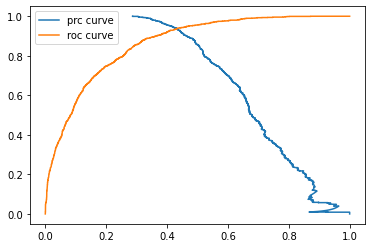

In [130]:
y = train_data[target_col]
p = model.predict(train_data[cat_cols_ + num_cols_])
scores = model.predict_proba(train_data[cat_cols_ + num_cols_])[:,1]
precision, recall, thresholds = precision_recall_curve(y, scores)
fpr, tpr, thresholds = roc_curve(y, scores)
plt.plot(precision, recall, label='prc curve')
plt.plot(fpr, tpr, label='roc curve')
plt.legend();

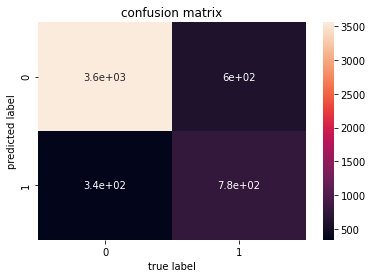

In [496]:
mat = confusion_matrix(y, p)
sns.heatmap(mat.T, annot=True)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('confusion matrix');

In [122]:
# LogisticRegression (kaggle 0.85361)

def prepare_data(data, train=False):
    
    if train: data = data[((data['ClientPeriod'] <= 69.5) & (data['Churn'] == 1) | (data['Churn'] == 0))].copy()
    
    replace_zeros = lambda x: x.replace(0, x.median())
    data['ClientPeriod'] = data.groupby('HasContractPhone')['ClientPeriod'].apply(replace_zeros)
    data['MonthlySpending'] = data.groupby('HasContractPhone')['MonthlySpending'].apply(replace_zeros)
    
    data['ClientPeriodG'] = pd.cut(data['ClientPeriod'], bins=[-1,0,2,5,10,17,25,33,43,53,62,70,72,100]).astype(str)
    data['MonthlySpendingG'] = pd.cut(data['MonthlySpending'], bins=np.arange(17.5,125,5)).astype(str)
    return data

test_data = prepare_data(pd.read_csv('./test.csv'), train=False)
train_data = prepare_data(pd.read_csv('./train.csv'), train=True)

num_cols_ = []
cat_cols_ = cat_cols + ['MonthlySpendingG','ClientPeriodG']
num_tran, cat_tran = StandardScaler(), OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer([('cat', cat_tran, cat_cols_), ('num', num_tran, num_cols_)])
classifier = LogisticRegression(C=1, penalty='l1', solver='liblinear')
model = Pipeline([('pre', preprocessor), ('clf', classifier)])
shuffle = StratifiedKFold(n_splits=30, shuffle=True, random_state=42)
s = cross_val_score(model, train_data[cat_cols_ + num_cols_], train_data[target_col], scoring='roc_auc', cv=shuffle)
print(f'roc_auc: {s.mean():.4f} (mean), {s.std():.4f} (std)')
print(f'scores: {s}')

model.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
submission = pd.read_csv('./submission.csv')
submission['Churn'] = model.predict_proba(test_data[cat_cols_ + num_cols_])[:,1]
submission.to_csv('./my_submission.csv', index=False)

c = np.abs(model['clf'].coef_)
print(f'coef_: {c.min():.3f} (min), {c.max():.3f} (max), {(c==0).sum()} / {len(c[0])} (zeros)')

roc_auc: 0.8550 (mean), 0.0317 (std)
scores: [0.8319398  0.91095318 0.88913043 0.87617057 0.82198997 0.87048495
 0.87257525 0.86103679 0.77274247 0.86404682 0.81505017 0.89498328
 0.84397993 0.88444816 0.88888889 0.89982906 0.8425641  0.89136752
 0.8757265  0.85478632 0.87521368 0.86717949 0.85863248 0.81410256
 0.81820513 0.81760684 0.83547009 0.81863248 0.83358611 0.84984833]
coef_: 0.000 (min), 3.701 (max), 18 / 75 (zeros)


In [126]:
# LogisticRegression (kaggle 0.85303)

def prepare_data(data):
    data['ClientPeriod'] = data.groupby('HasContractPhone')['ClientPeriod'].apply(lambda x: x.replace(0, x.median()))
    data['ClientPeriodG'] = pd.cut(data['ClientPeriod'], bins=[-1,0,2,5,10,17,25,33,43,53,62,70,72,100]).astype(str)
    data['MonthlySpendingG'] = pd.cut(data['MonthlySpending'], bins=np.arange(17.5,125,5)).astype(str)
    return data

test_data = prepare_data(pd.read_csv('./test.csv'))
train_data = prepare_data(pd.read_csv('./train.csv'))

num_cols_ = []
cat_cols_ = cat_cols + ['ClientPeriodG','MonthlySpendingG']
num_tran, cat_tran = StandardScaler(), OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer([('cat', cat_tran, cat_cols_), ('num', num_tran, num_cols_)])
classifier = LogisticRegression(C=1, penalty='l1', solver='liblinear')
model = Pipeline([('pre', preprocessor), ('clf', classifier)])
shuffle = StratifiedKFold(n_splits=30, shuffle=True, random_state=42)
s = cross_val_score(model, train_data[cat_cols_ + num_cols_], train_data[target_col], scoring='roc_auc', cv=shuffle)
print(f'roc_auc: {s.mean():.4f} (mean), {s.std():.4f} (std)')
print(f'scores: {s}')

model.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
submission = pd.read_csv('./submission.csv')
submission['Churn'] = model.predict_proba(test_data[cat_cols_ + num_cols_])[:,1]
submission.to_csv('./my_submission.csv', index=False)

c = np.abs(model['clf'].coef_)
print(f'coef_: {c.min():.3f} (min), {c.max():.3f} (max), {(c==0).sum()} / {len(c[0])} (zeros)')

roc_auc: 0.8492 (mean), 0.0342 (std)
scores: [0.76325696 0.87307692 0.84573579 0.8493311  0.82792642 0.87826087
 0.87901338 0.91379599 0.80501672 0.91137124 0.84899666 0.88494983
 0.82466555 0.83444816 0.86923077 0.84297659 0.86471572 0.85702341
 0.87474916 0.87165552 0.86070234 0.87006689 0.86688963 0.815301
 0.86755853 0.78779264 0.82324415 0.81956522 0.85304305 0.79209962]
coef_: 0.000 (min), 1.709 (max), 22 / 75 (zeros)


In [127]:
# CatBoostClassifier (kaggle 0.85283)

def prepare_data(data):
    data['TotalSpent'] = pd.to_numeric(data['TotalSpent'], errors='coerce')
    data['TotalSpent'] = data['TotalSpent'].fillna(0)
    return data

test_data = prepare_data(pd.read_csv('./test.csv'))
train_data = prepare_data(pd.read_csv('./train.csv'))

num_cols_ = num_cols
cat_cols_ = cat_cols
catboost = CatBoostClassifier(learning_rate=0.16, num_trees=63)
catboost.set_params(cat_features=cat_cols_, silent=True)
s = cross_val_score(catboost, train_data[cat_cols_ + num_cols_], train_data[target_col], scoring='roc_auc', cv=10)
print(f'roc_auc: {s.mean():.4f} (mean), {s.std():.4f} (std)')
print(f'scores: {s}')

catboost.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
submission = pd.read_csv('./submission.csv')
submission['Churn'] = catboost.predict_proba(test_data[cat_cols_ + num_cols_])[:,1]
submission.to_csv('./my_submission.csv', index=False)

roc_auc: 0.8480 (mean), 0.0110 (std)
scores: [0.85309906 0.86536617 0.85293571 0.83297101 0.85815682 0.82840951
 0.84746377 0.85682832 0.84400141 0.84039504]


In [ ]:
grid = {'learning_rate':[0.155,0.16,0.165], 'num_trees':[60,61,62,63,64]}
catboost = CatBoostClassifier().set_params(cat_features=cat_cols, silent=True)
cv = GridSearchCV(catboost, grid, scoring='roc_auc', cv=10)
cv.fit(train_data[cat_cols_ + num_cols_], train_data[target_col])
params = cv.best_estimator_.get_params()
params['learning_rate'], params['num_trees']